<a href="https://colab.research.google.com/github/aleks-haksly/ClickHouse/blob/main/practice/part_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
!pip install clickhouse_driver --quiet
from clickhouse_driver import Client
!pip install prophet --quiet
from prophet import Prophet
import holidays
from google.colab import userdata
import ipywidgets as widgets
import plotly.graph_objects as go

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.1/935.1 kB 3.2 MB/s eta 0:00:00


In [2]:
# connection requisites
host = 'clickhouse.lab.karpov.courses'
dbase = 'default'
port = 9000
user = 'student'
password = userdata.get('ch2020[student]')

In [3]:
client = Client(host=host, port=port, user=user,
                password=password, database=dbase)

## [Prophet](https://github.com/facebook/prophet) for producing high quality forecasts for time series data that has multiple seasonality with linear or non-linear growth


### Задание 6.1
Задача прогнозирования временных рядов. Будем прогнозировать органические установки приложения по базе [Mobile installs](https://github.com/aleks-haksly/ClickHouse/tree/main/practice#mobile-installs)

In [4]:
sql = f"""
SELECT
  ds,
  uniqExact(DeviceID) as y
FROM installs
WHERE
  Source = 'Source_27' AND
  InstallCost = 0
GROUP BY toDateOrNull(InstallationDate) as ds
ORDER BY ds
"""
result, columns = client.execute(sql, with_column_types=True)
df = pd.DataFrame(result, columns=[tuple[0] for tuple in columns])

In [5]:
# починим колонку ds
df['ds'] = pd.to_datetime(df['ds'])
df.head()

,ds,y
0,2019-01-01,26243
1,2019-01-02,31303
2,2019-01-03,34017
3,2019-01-04,33807
4,2019-01-05,33925


In [6]:
holidays_dict = holidays.RUS([2015, 2016, 2017, 2018, 2019, 2020, 2021])

In [7]:
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index').reset_index()
df_holidays['index'] = pd.to_datetime(df_holidays['index'])
df_holidays = df_holidays.sort_values('index').rename(columns={'index': 'ds', 0: 'holiday'}).reset_index(drop=True)

In [8]:
n_predictions = 30
df_train = df[:-n_predictions]
df_test = df[-n_predictions:]

In [9]:
model = Prophet(holidays=df_holidays, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False)
model.fit(df_train);

DEBUG:cmdstanpy:input tempfile: /tmp/tmp64ay11mu/vvjh63p0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp64ay11mu/pdbz8o6w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8773', 'data', 'file=/tmp/tmp64ay11mu/vvjh63p0.json', 'init=/tmp/tmp64ay11mu/pdbz8o6w.json', 'output', 'file=/tmp/tmp64ay11mu/prophet_modelbrwo53rl/prophet_model-20240513075730.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:57:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [10]:
future = model.make_future_dataframe(periods=n_predictions)
forecast = model.predict(future)

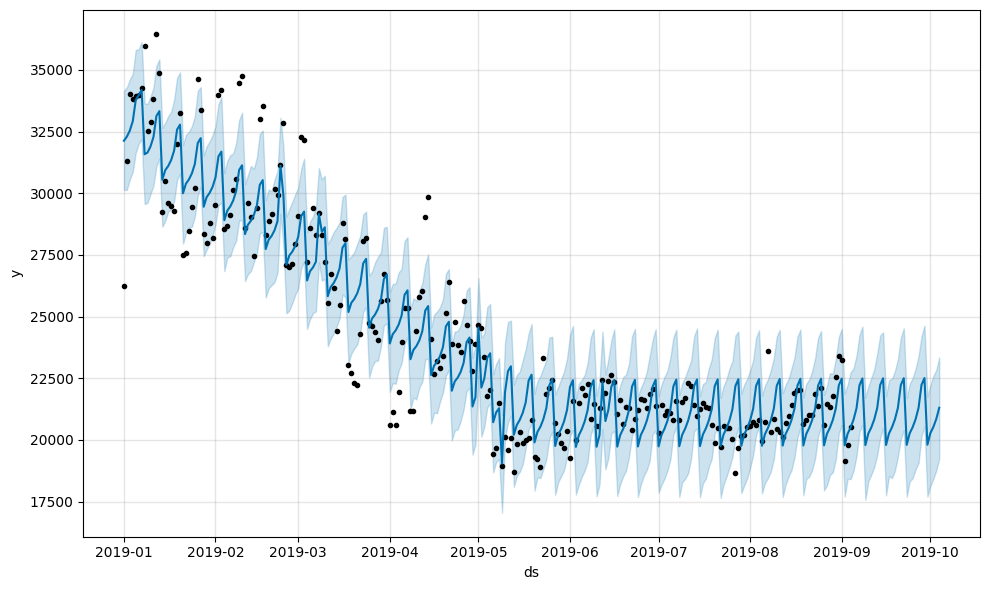

In [11]:
model.plot(forecast);

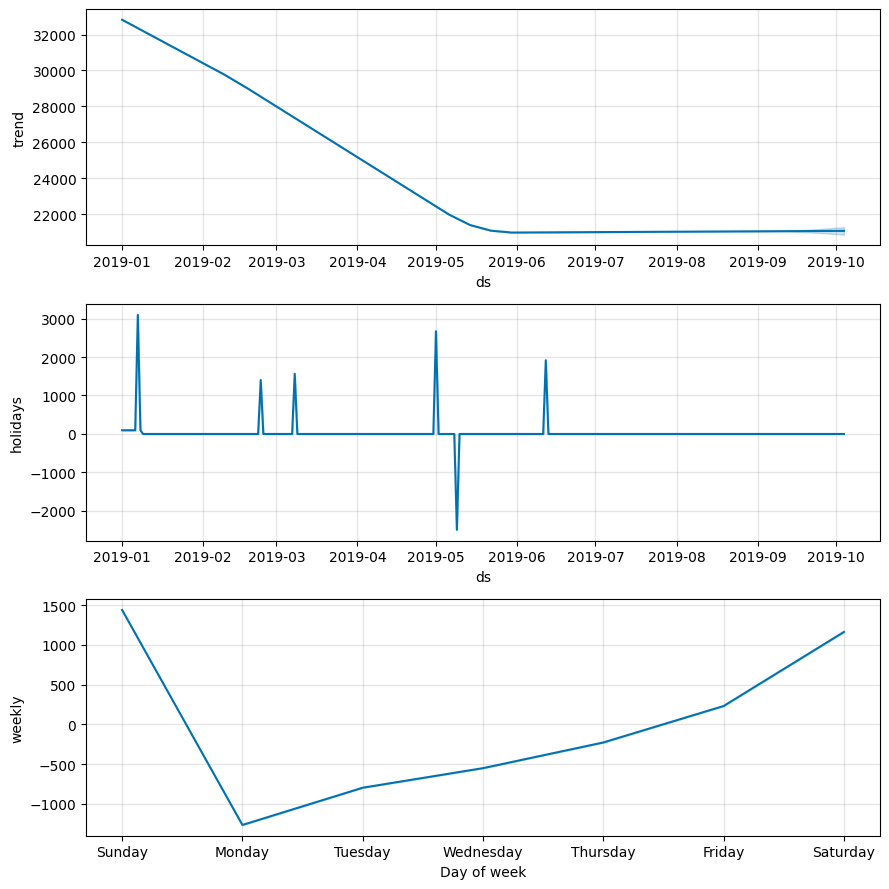

In [22]:
 model.plot_components(forecast);

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df['ds'], y=df['y'],
    name='fact',
    mode='lines',
))
fig.add_trace(go.Scatter(
    x=forecast['ds'], y=forecast['yhat'],
    name='prediction',
    mode='lines',
))
fig.add_trace(go.Scatter(
    x=forecast['ds'], y=forecast['yhat_upper'],
    name='upper',
    mode='none',
    fill='tonexty'
))
fig.add_trace(go.Scatter(
    x=forecast['ds'], y=forecast['yhat_lower'],
    name='lower',
    mode='none',
    fill='tonexty'
))
fig.add_trace(go.Scatter(
    x=forecast['ds'], y=forecast['trend'],
    name='trend'
))
fig.update_layout(title='Installations prediction')

In [39]:
# Посчитаем среднюю абюсолютную ошибку и среднюю аюсолютную ошибку в процентах
MAE = round(np.mean(abs(np.asarray(forecast['yhat']) - np.asarray(df['y']))[-n_predictions:]))
MAE_p = round(np.mean((abs(np.asarray(forecast['yhat']) - np.asarray(df['y'])) / abs(np.asarray(df['y']))*100)[-n_predictions:]), 2)
print(f'MAE: {MAE}')
print(f'MAE %: {MAE_p}')

MAE: 1080
MAE %: 5.56
